# Just The Basics - Strata 2013 | Predicting Spam Emails

Hello! I wanted to move onto natrual language processing by next week, but I also wanted some more practice with tabular data sets. And, what better way than to use a data set that's related to natural language: emails. 

[This](https://www.kaggle.com/competitions/just-the-basics-the-after-party/overview) Kaggle competition ran 9 years ago and is one of the "getting started" data sets. This data set contains "100 features extracted from a corpus of emails. Some of the emails are spam and some are normal. [Our] task is to make a spam detector."

In [ ]:
#hide
!pip install -Uqq fastbook kaggle
!pip install tornado==5.1.0
import fastbook
fastbook.setup_book()

In [ ]:
#hide
from google.colab import drive
drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


In [ ]:
#hide
%mkdir /content/gdrive/MyDrive/data_sets/strata

mkdir: cannot create directory ‘/content/gdrive/MyDrive/data_sets/strata’: File exists


In [ ]:
#hide
%cd /content/gdrive/MyDrive/data_sets/strata

/content/gdrive/MyDrive/data_sets/strata


In [ ]:
#hide
%cp ../bluebook/kaggle.json ../

In [ ]:
#hide
import os
os.environ['KAGGLE_CONFIG_DIR'] = '/content/gdrive/MyDrive/data_sets/'

In [ ]:
#hide
!kaggle competitions download -c just-the-basics-the-after-party

just-the-basics-the-after-party.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
#hide
!ls

just-the-basics-the-after-party.zip  test.csv	train_labels.csv
kaggle.json			     train.csv


In [ ]:
#hide
!7z x just-the-basics-the-after-party.zip

In [ ]:
#hide
!ls

just-the-basics-the-after-party.zip  test.csv	train_labels.csv
kaggle.json			     train.csv


In [ ]:
#hide
from fastbook import *
from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype
from fastai.tabular.all import *
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn import metrics

I've already downloaded the data set and we can first import them:

In [ ]:
xs   = pd.read_csv('train.csv', low_memory=False)
y    = pd.read_csv('train_labels.csv', low_memory=False)
test = pd.read_csv('test.csv', low_memory=False)

Then, we'll define functions for our random forest trainer and the metric that this competition requires, which is the area under the [ROC curve](https://en.wikipedia.org/wiki/Receiver_operating_characteristic). 

In [ ]:
def rf(xs, y, n_estimators=40, min_samples_leaf=5, max_samples=300,
       max_features=0.5):
    return RandomForestRegressor(n_estimators=n_estimators,
                                 min_samples_leaf=min_samples_leaf,
                                 max_samples=max_samples,
                                 max_features=max_features,
                                 oob_score=True, n_jobs=-1).fit(xs, y)

In [ ]:
def a_uc(preds, y):
    fpr, tpr, thresholds = metrics.roc_curve(y, preds, pos_label=1)
    return metrics.auc(fpr, tpr)

def m_auc(m, xs, y):
    return a_uc(m.predict(xs), y)

In making our `TabularPandas`, we'll merge the independent and dependent variables. But, unlike before we'll be using a randomized split since this isn't a time series.

In [ ]:
df_merged = pd.concat((xs, y), axis=1).copy()

In [ ]:
procs = [Categorify, FillMissing, Normalize]

In [ ]:
cont, cat = cont_cat_split(df_merged, dep_var='0')

In [ ]:
tp = TabularPandas(df_merged, procs, cat_names=cat, cont_names=cont, y_names='0', splits=RandomSplitter()(xs))

In [ ]:
t_xs, v_xs, t_y, v_y = tp.train.xs, tp.valid.xs, tp.train.y, tp.valid.y

I'm not sure how to use `TabularPandas` that well since there's no categorical columns in this data set, but it seems like `TabularPandas` requires it. If there aren't any, then it duplicates all the columns, so we remove them here:

In [ ]:
t_xs = t_xs.drop(tp.train.x_names[0:100], axis=1)

In [ ]:
v_xs = v_xs.drop(tp.valid.x_names[0:100], axis=1)

Then, we train a decision tree as a baseline:

In [ ]:
dt = DecisionTreeRegressor(min_samples_leaf=40).fit(t_xs, t_y)

In [ ]:
m_auc(dt, t_xs, t_y), m_auc(dt, v_xs, v_y)

(0.9117870857001292, 0.9124478856462179)

Surprisingly, the baseline is already at 0.912. I'm also not sure if this metric is [equivalent to accuracy](https://neptune.ai/blog/f1-score-accuracy-roc-auc-pr-auc) in terms of saying it's 91.2% accurate, so I'll just refer to it as 0.912. 

Next, let's train a random forest model:

In [ ]:
m = rf(t_xs, t_y, min_samples_leaf=10, n_estimators=120)

In [ ]:
m_auc(m, t_xs, t_y), m_auc(m, v_xs, v_y)

(0.9765178460830635, 0.9401429422275164)

And then, we'll train a neural network:

In [ ]:
dls = tp.dataloaders(128)

Again, we're dropping the duplicated columns from `TabularPandas`:

In [ ]:
dls.train.xs = dls.train.xs.drop(columns=dls.train.x_names[0:100])
dls.valid.xs = dls.valid.xs.drop(columns=dls.valid.x_names[0:100])

In [ ]:
learn = tabular_learner(dls, y_range=(0, 1.1), n_out=1)

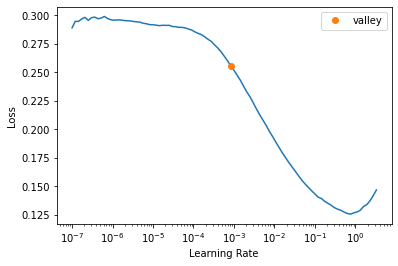

In [ ]:
lr = learn.lr_find().valley

In [ ]:
#collapse_output
learn.fit_one_cycle(20, lr)

epoch,train_loss,valid_loss,time
0,0.289919,0.264292,00:00
1,0.280569,0.260043,00:00
2,0.264891,0.248970,00:00
3,0.243126,0.230470,00:00
4,0.218251,0.207044,00:00
5,0.195376,0.184551,00:00
6,0.175897,0.165676,00:00
7,0.158557,0.149466,00:00
8,0.143941,0.136603,00:00
9,0.131354,0.127658,00:00


In [ ]:
preds, targs = learn.get_preds()

In [ ]:
a_uc(preds, targs)

0.9252531268612271

Finally, we ensemble the predictions from our baseline (since it's not far off from the neural network's ROC AUC), random forest model, and neural network:

In [ ]:
rf_preds = m.predict(v_xs)
ens_preds = (to_np(preds.squeeze()) + rf_preds + dt.predict(v_xs)) / 3

In [ ]:
a_uc(ens_preds, v_y)

0.953543776057177

From a fairly quick model with no really "complex" components added (that I would probably learn in the second part of fast.ai), we're able to come 36th in the leaderboards (which is top 75%). 

Anyway, this post is just a quick recap on tabular model training using a relatively small data set. We didn't need to preprocess the data since `TabularPandas` handles the missing values for us. We trained a baseline, then trained a random forest and a neural network model, then ensembled the predictions. Perhaps I could have analyzed the columns and remove some of the unimportant features. Unlike last time, there aren't any categorical columns so I didn't use the embeddings to train another random forest model. 

Maybe in the future I'll revisit this data set and aim to get a higher score. 